# 1. Análisis Exploratorio de Datos (EDA) - Consumo Eléctrico PJM East

Este notebook realiza un análisis exploratorio completo de la serie temporal de consumo eléctrico horario de la región PJM East (Eastern Interconnection).

## Objetivo:
Comprender el comportamiento de los datos antes de aplicar modelos predictivos, identificando patrones, tendencias y anomalías.

## Contenido:
1. **Importación de Librerías y Carga de Datos** - Importación, limpieza y exploración inicial
2. **Visualización Temporal Completa** - Análisis de tendencia y ruido
3. **Análisis de Estacionalidad**
   - 3.1 Diaria: Picos de consumo (mañana/noche)
   - 3.2 Semanal: Diferencia entre días laborables y fines de semana
   - 3.3 Anual: Impacto de las estaciones (verano/invierno)
4. **Identificación de Outliers** - Detección de valores atípicos
5. **Resumen Ejecutivo del EDA** - Conclusiones principales del análisis

---
## 1. Importación de Librerías y Carga de Datos

In [26]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [27]:
# Cargar el dataset
df = pd.read_csv('PJME_hourly.csv', parse_dates=['Datetime'])

# Ordenar por fecha y establecer como índice
df = df.sort_values('Datetime').reset_index(drop=True)
df.set_index('Datetime', inplace=True)

print(f"Dataset cargado exitosamente")
print(f"   - Registros: {len(df):,}")
print(f"   - Período: {df.index.min()} a {df.index.max()}")
print(f"   - Duración: {(df.index.max() - df.index.min()).days / 365:.1f} años")

Dataset cargado exitosamente
   - Registros: 145,366
   - Período: 2002-01-01 01:00:00 a 2018-08-03 00:00:00
   - Duración: 16.6 años


In [28]:
# Vista previa de los datos
print("Primeras filas del dataset:")
df.head(10)

Primeras filas del dataset:


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
2002-01-01 06:00:00,28654.0
2002-01-01 07:00:00,29308.0
2002-01-01 08:00:00,29595.0
2002-01-01 09:00:00,29943.0


In [29]:
# Información general del dataset
print("\nInformación del Dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
df.describe().round(2)


Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None

Estadísticas descriptivas:


,PJME_MW
count,145366.00
mean,32080.22
std,6464.01
min,14544.00
25%,27573.00
50%,31421.00
75%,35650.00
max,62009.00


In [30]:
# Verificar valores nulos
print("\n Valores nulos por columna:")
print(df.isnull().sum())

# Verificar duplicados
duplicados = df.index.duplicated().sum()
print(f"\n Registros duplicados: {duplicados}")


 Valores nulos por columna:
PJME_MW    0
dtype: int64

 Registros duplicados: 4


---
## 2. Visualización Temporal Completa: Tendencia y Ruido

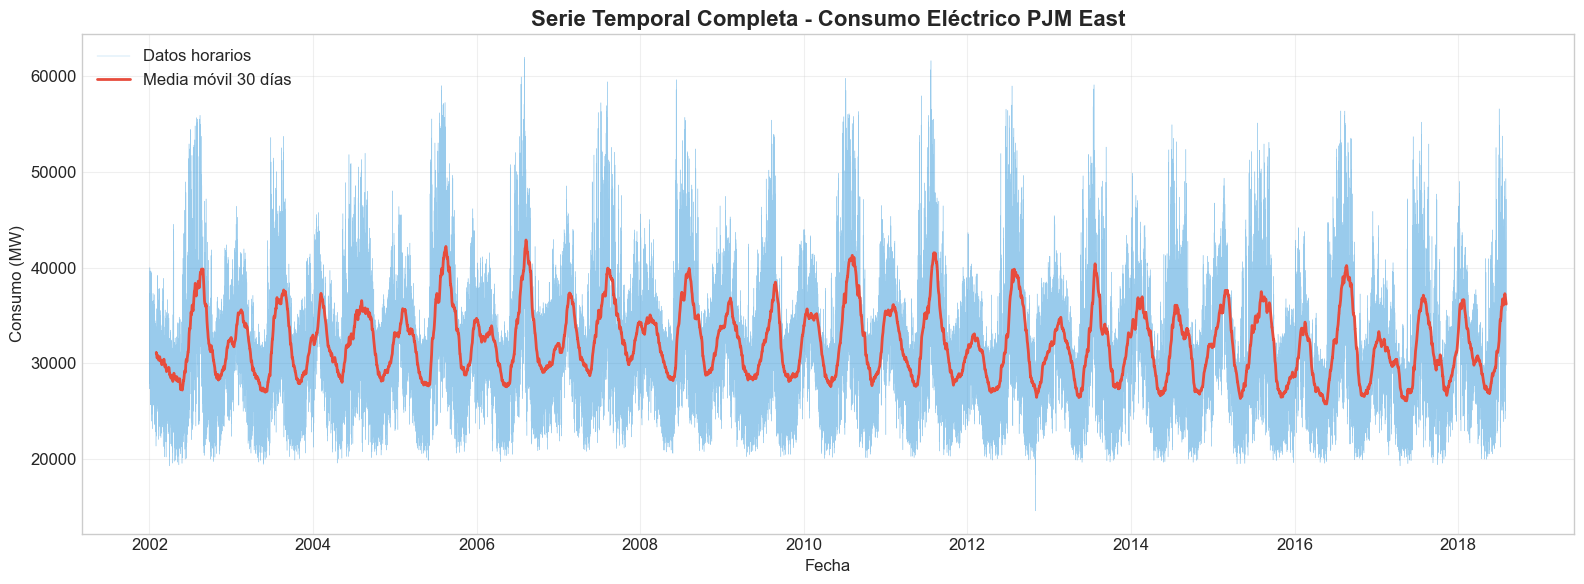

In [31]:
# Serie temporal completa
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df.index, df['PJME_MW'], color='#3498db', alpha=0.5, linewidth=0.3, label='Datos horarios')

# Añadir media móvil para ver tendencia
df['MA_30D'] = df['PJME_MW'].rolling(window=24*30).mean()  # Media móvil 30 días
ax.plot(df.index, df['MA_30D'], color='#e74c3c', linewidth=2, label='Media móvil 30 días')

ax.set_title('Serie Temporal Completa - Consumo Eléctrico PJM East', fontsize=16, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Consumo (MW)', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

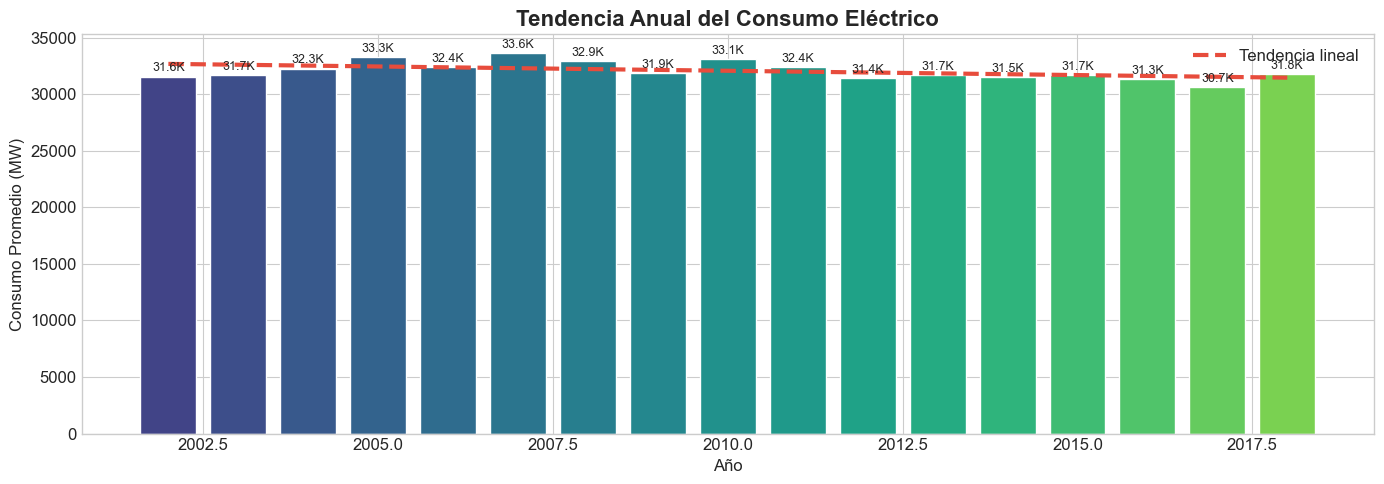


Tasa de crecimiento total del período: 0.69%


In [32]:
# Análisis de tendencia por año
yearly_avg = df['PJME_MW'].resample('Y').mean()

fig, ax = plt.subplots(figsize=(14, 5))

bars = ax.bar(yearly_avg.index.year, yearly_avg.values, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(yearly_avg))), 
              edgecolor='white', linewidth=1)

# Línea de tendencia
z = np.polyfit(range(len(yearly_avg)), yearly_avg.values, 1)
p = np.poly1d(z)
ax.plot(yearly_avg.index.year, p(range(len(yearly_avg))), color='#e74c3c', 
        linestyle='--', linewidth=3, label=f'Tendencia lineal')

ax.set_title('Tendencia Anual del Consumo Eléctrico', fontsize=16, fontweight='bold')
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Consumo Promedio (MW)', fontsize=12)
ax.legend()

# Añadir valores sobre las barras
for bar, val in zip(bars, yearly_avg.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, 
            f'{val/1000:.1f}K', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Calcular tasa de crecimiento
growth_rate = ((yearly_avg.iloc[-1] / yearly_avg.iloc[0]) - 1) * 100
print(f"\nTasa de crecimiento total del período: {growth_rate:.2f}%")

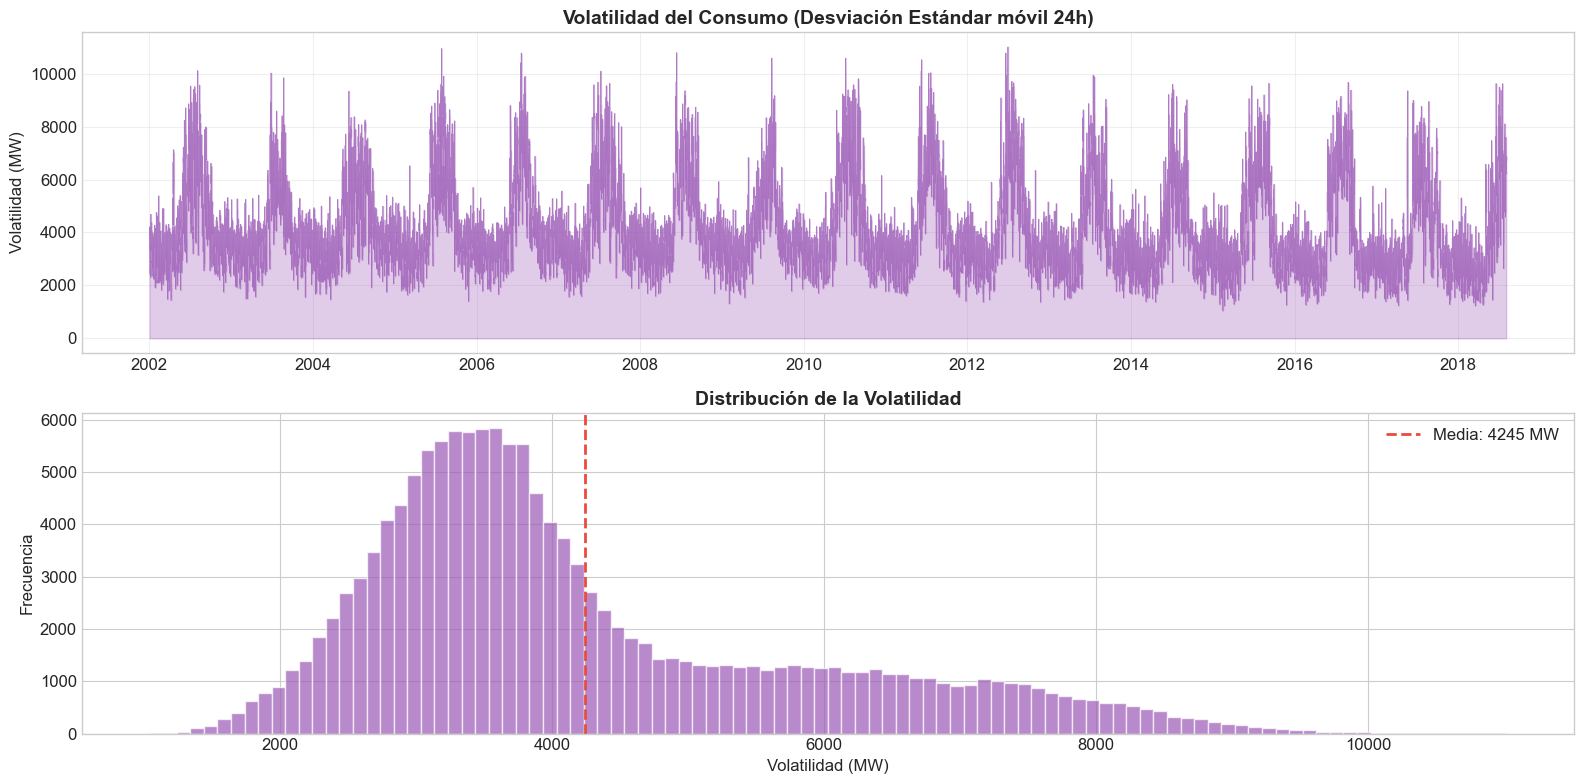

In [33]:
# Análisis de ruido (volatilidad)
df['Volatilidad_24h'] = df['PJME_MW'].rolling(window=24).std()

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Gráfico 1: Volatilidad diaria
axes[0].plot(df.index, df['Volatilidad_24h'], color='#9b59b6', alpha=0.7, linewidth=0.5)
axes[0].fill_between(df.index, df['Volatilidad_24h'], alpha=0.3, color='#9b59b6')
axes[0].set_title('Volatilidad del Consumo (Desviación Estándar móvil 24h)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Volatilidad (MW)')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Histograma de la volatilidad
axes[1].hist(df['Volatilidad_24h'].dropna(), bins=100, color='#9b59b6', edgecolor='white', alpha=0.7)
axes[1].axvline(df['Volatilidad_24h'].mean(), color='#e74c3c', linestyle='--', linewidth=2, 
                label=f'Media: {df["Volatilidad_24h"].mean():.0f} MW')
axes[1].set_title('Distribución de la Volatilidad', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Volatilidad (MW)')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 3. Análisis de Estacionalidad

### 3.1 Estacionalidad Diaria: Picos de consumo (mañana/noche)

In [34]:
# Extraer características temporales
df['Hora'] = df.index.hour
df['DiaSemana'] = df.index.dayofweek  # 0=Lunes, 6=Domingo
df['Mes'] = df.index.month
df['Año'] = df.index.year
df['DiaNombre'] = df.index.day_name()
df['EsFinDeSemana'] = df['DiaSemana'].isin([5, 6]).astype(int)

print("Características temporales extraídas")

Características temporales extraídas


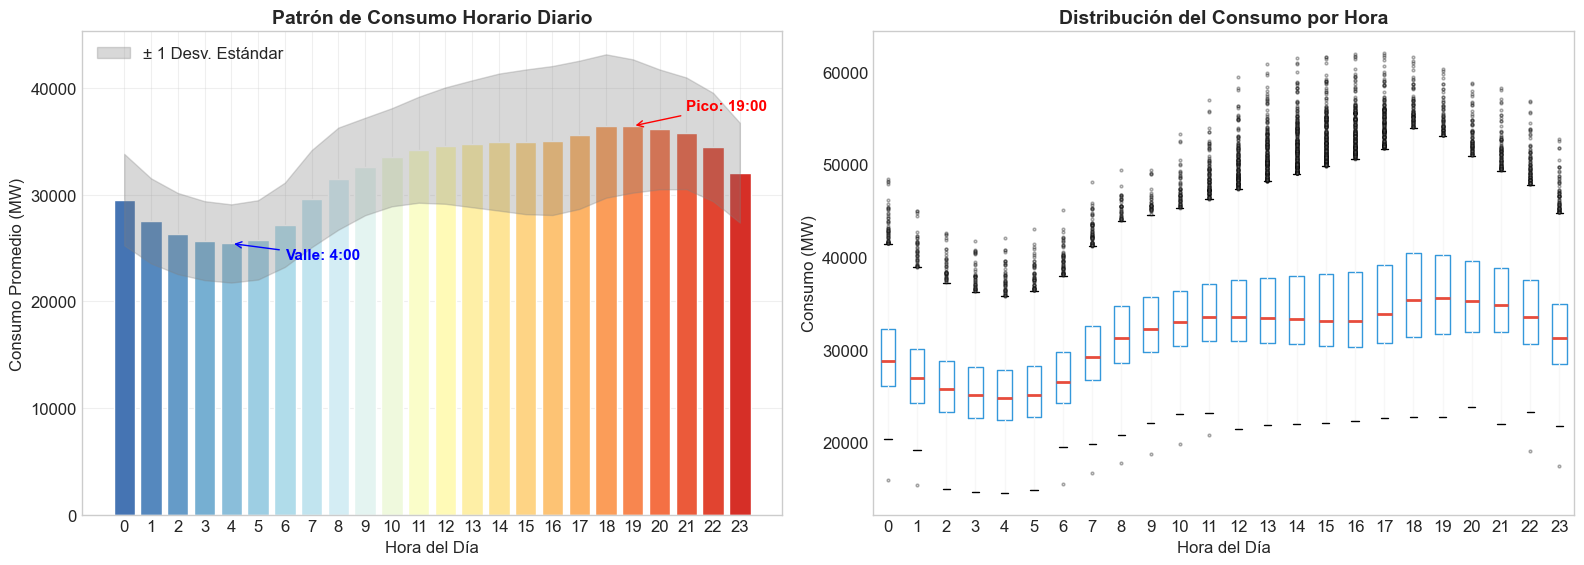


Análisis de Picos Diarios:
   Hora de máximo consumo: 19:00 (36,427 MW promedio)
   Hora de mínimo consumo: 4:00 (25,415 MW promedio)
   Diferencia pico-valle: 11,012 MW


In [35]:
# Patrón de consumo por hora del día
hourly_pattern = df.groupby('Hora')['PJME_MW'].agg(['mean', 'std', 'min', 'max'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Consumo promedio por hora
colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, 24))
bars = axes[0].bar(hourly_pattern.index, hourly_pattern['mean'], color=colors, edgecolor='white', linewidth=1)
axes[0].fill_between(hourly_pattern.index, 
                     hourly_pattern['mean'] - hourly_pattern['std'],
                     hourly_pattern['mean'] + hourly_pattern['std'], 
                     alpha=0.3, color='gray', label='± 1 Desv. Estándar')
axes[0].set_title('Patrón de Consumo Horario Diario', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hora del Día')
axes[0].set_ylabel('Consumo Promedio (MW)')
axes[0].set_xticks(range(0, 24))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Marcar picos
max_hour = hourly_pattern['mean'].idxmax()
min_hour = hourly_pattern['mean'].idxmin()
axes[0].annotate(f'Pico: {max_hour}:00', xy=(max_hour, hourly_pattern.loc[max_hour, 'mean']),
                 xytext=(max_hour+2, hourly_pattern.loc[max_hour, 'mean']+1500),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=11, color='red', fontweight='bold')
axes[0].annotate(f'Valle: {min_hour}:00', xy=(min_hour, hourly_pattern.loc[min_hour, 'mean']),
                 xytext=(min_hour+2, hourly_pattern.loc[min_hour, 'mean']-1500),
                 arrowprops=dict(arrowstyle='->', color='blue'),
                 fontsize=11, color='blue', fontweight='bold')

# Gráfico 2: Boxplot por hora
df.boxplot(column='PJME_MW', by='Hora', ax=axes[1], grid=False, 
           boxprops=dict(color='#3498db'),
           medianprops=dict(color='#e74c3c', linewidth=2),
           flierprops=dict(marker='o', markerfacecolor='gray', markersize=2, alpha=0.3))
axes[1].set_title('Distribución del Consumo por Hora', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hora del Día')
axes[1].set_ylabel('Consumo (MW)')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nAnálisis de Picos Diarios:")
print(f"   Hora de máximo consumo: {max_hour}:00 ({hourly_pattern.loc[max_hour, 'mean']:,.0f} MW promedio)")
print(f"   Hora de mínimo consumo: {min_hour}:00 ({hourly_pattern.loc[min_hour, 'mean']:,.0f} MW promedio)")
print(f"   Diferencia pico-valle: {(hourly_pattern.loc[max_hour, 'mean'] - hourly_pattern.loc[min_hour, 'mean']):,.0f} MW")

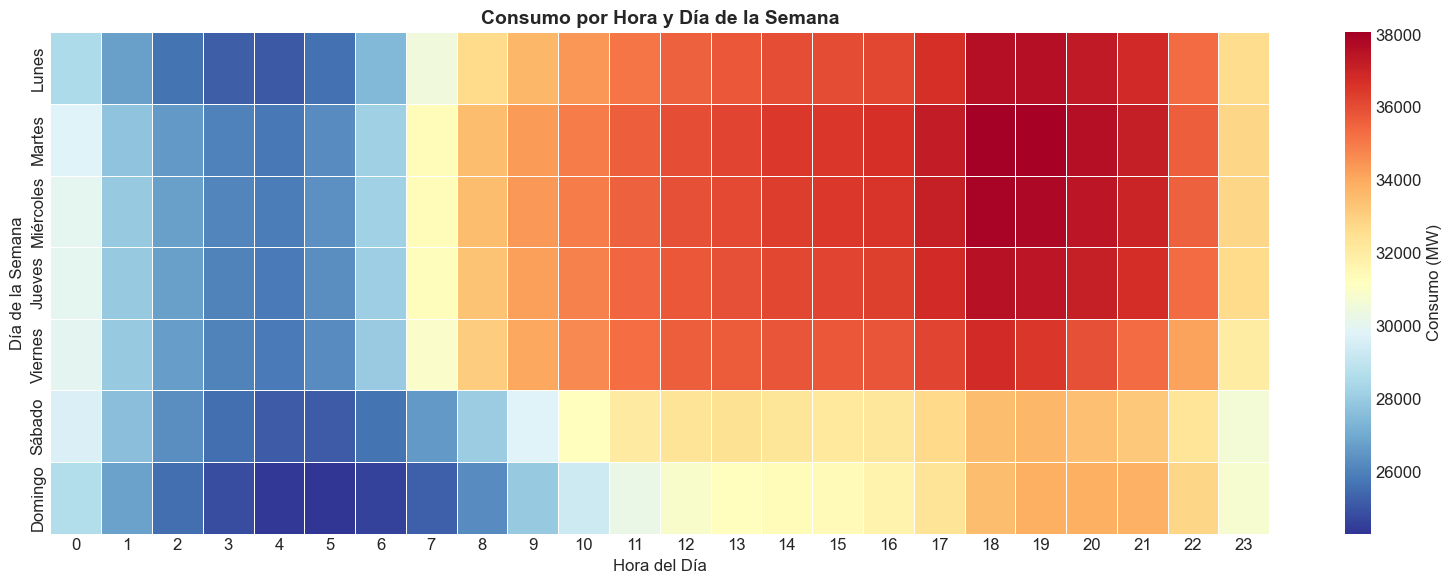

In [36]:
# Heatmap de consumo por hora y día de la semana
pivot_hora_dia = df.pivot_table(values='PJME_MW', index='DiaSemana', columns='Hora', aggfunc='mean')
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
pivot_hora_dia.index = dias_semana

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot_hora_dia, cmap='RdYlBu_r', annot=False, fmt='.0f', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Consumo (MW)'})
ax.set_title('Consumo por Hora y Día de la Semana', fontsize=14, fontweight='bold')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Día de la Semana')

plt.tight_layout()
plt.show()

### 3.2 Estacionalidad Semanal: Laborables vs Fines de Semana

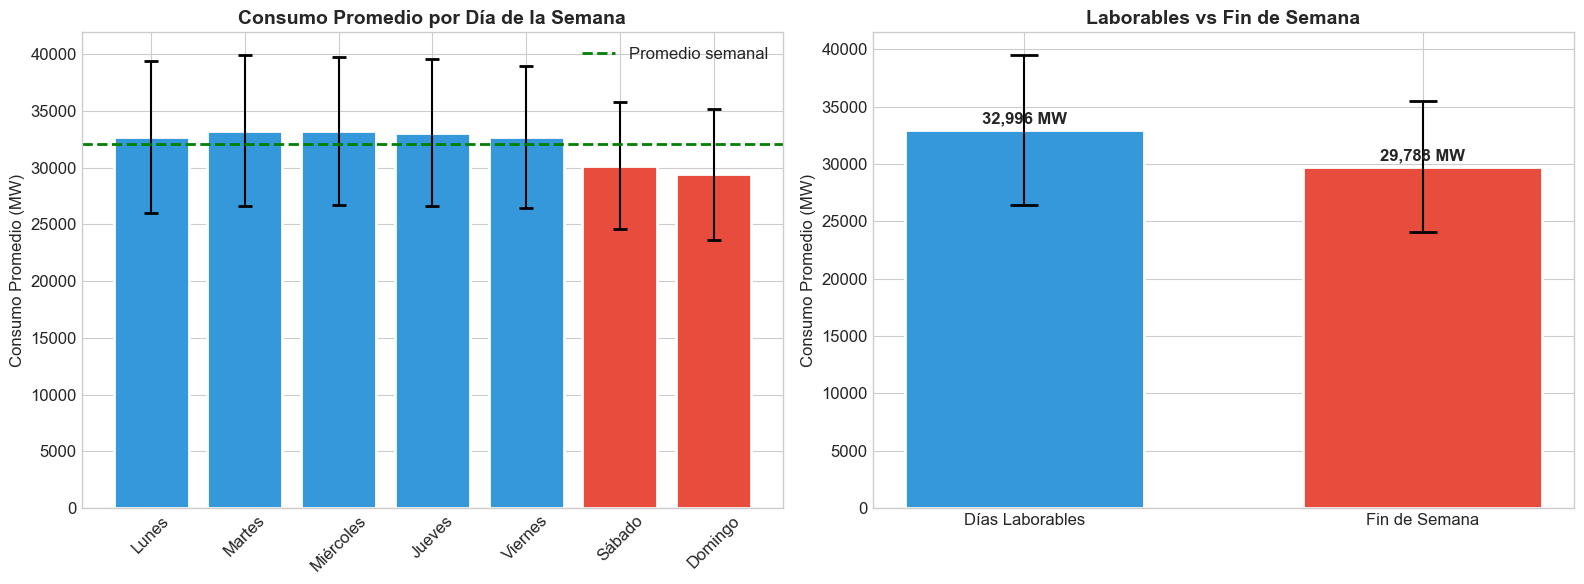


Análisis Semanal:
   Los días laborables tienen 10.8% más consumo que los fines de semana


In [37]:
# Consumo promedio por día de la semana
weekly_pattern = df.groupby('DiaSemana')['PJME_MW'].agg(['mean', 'std'])
weekly_pattern.index = dias_semana

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Barras por día de la semana
colors = ['#3498db']*5 + ['#e74c3c']*2  # Azul para laborables, rojo para fin de semana
bars = axes[0].bar(weekly_pattern.index, weekly_pattern['mean'], color=colors, edgecolor='white', linewidth=2)
axes[0].errorbar(range(7), weekly_pattern['mean'], yerr=weekly_pattern['std'], 
                 fmt='none', color='black', capsize=5, capthick=2)
axes[0].set_title('Consumo Promedio por Día de la Semana', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Consumo Promedio (MW)')
axes[0].axhline(y=weekly_pattern['mean'].mean(), color='green', linestyle='--', linewidth=2, label='Promedio semanal')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Comparación laborables vs fin de semana
weekday_weekend = df.groupby('EsFinDeSemana')['PJME_MW'].agg(['mean', 'std'])
weekday_weekend.index = ['Días Laborables', 'Fin de Semana']

colors_ww = ['#3498db', '#e74c3c']
bars2 = axes[1].bar(weekday_weekend.index, weekday_weekend['mean'], color=colors_ww, 
                    edgecolor='white', linewidth=2, width=0.6)
axes[1].errorbar(range(2), weekday_weekend['mean'], yerr=weekday_weekend['std'],
                 fmt='none', color='black', capsize=10, capthick=2)

# Añadir valores
for bar, val in zip(bars2, weekday_weekend['mean']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300, 
                 f'{val:,.0f} MW', ha='center', va='bottom', fontsize=12, fontweight='bold')

axes[1].set_title('Laborables vs Fin de Semana', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Consumo Promedio (MW)')

plt.tight_layout()
plt.show()

# Calcular diferencia porcentual
diff_pct = ((weekday_weekend.loc['Días Laborables', 'mean'] - weekday_weekend.loc['Fin de Semana', 'mean']) / 
            weekday_weekend.loc['Fin de Semana', 'mean']) * 100
print(f"\nAnálisis Semanal:")
print(f"   Los días laborables tienen {diff_pct:.1f}% más consumo que los fines de semana")

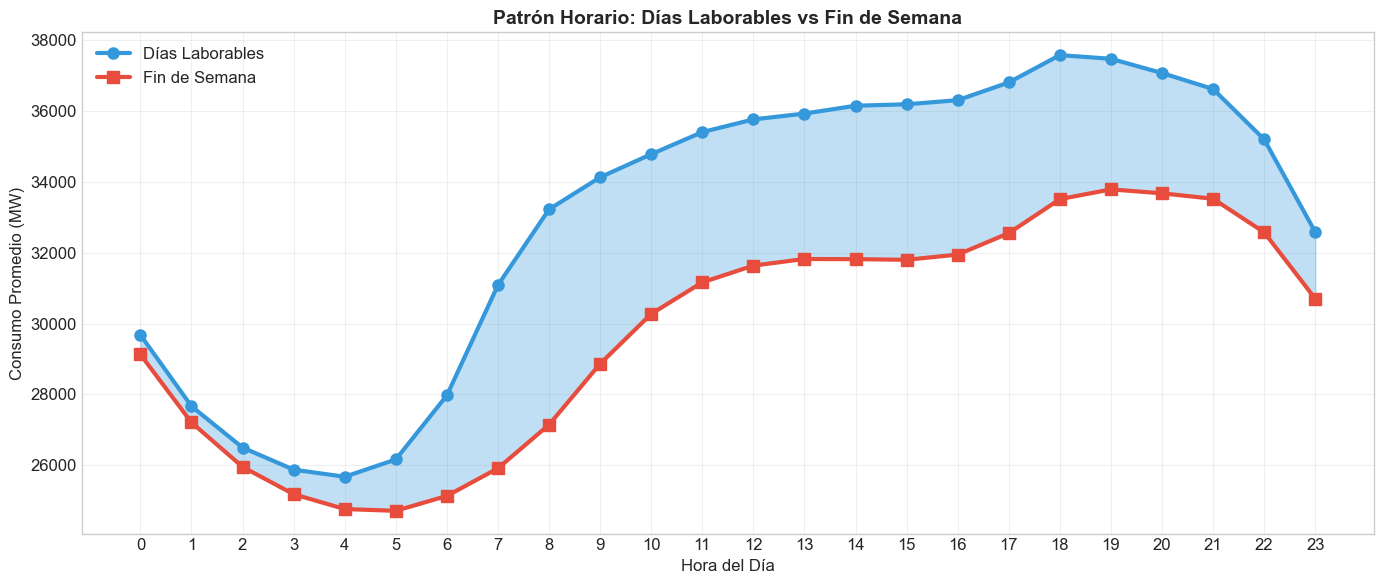

In [38]:
# Patrón horario: Laborables vs Fin de Semana
hourly_weekday = df[df['EsFinDeSemana'] == 0].groupby('Hora')['PJME_MW'].mean()
hourly_weekend = df[df['EsFinDeSemana'] == 1].groupby('Hora')['PJME_MW'].mean()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(hourly_weekday.index, hourly_weekday.values, 'o-', color='#3498db', 
        linewidth=3, markersize=8, label='Días Laborables')
ax.plot(hourly_weekend.index, hourly_weekend.values, 's-', color='#e74c3c', 
        linewidth=3, markersize=8, label='Fin de Semana')

ax.fill_between(hourly_weekday.index, hourly_weekday.values, hourly_weekend.values, 
                where=hourly_weekday.values >= hourly_weekend.values, 
                interpolate=True, alpha=0.3, color='#3498db')
ax.fill_between(hourly_weekday.index, hourly_weekday.values, hourly_weekend.values, 
                where=hourly_weekday.values < hourly_weekend.values, 
                interpolate=True, alpha=0.3, color='#e74c3c')

ax.set_title('Patrón Horario: Días Laborables vs Fin de Semana', fontsize=14, fontweight='bold')
ax.set_xlabel('Hora del Día')
ax.set_ylabel('Consumo Promedio (MW)')
ax.set_xticks(range(0, 24))
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Estacionalidad Anual: Impacto de las Estaciones

In [39]:
# Definir estaciones
def get_season(month):
    if month in [12, 1, 2]:
        return 'Invierno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

df['Estacion'] = df['Mes'].apply(get_season)

# Orden de las estaciones
season_order = ['Invierno', 'Primavera', 'Verano', 'Otoño']
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

print("Estaciones asignadas correctamente")

Estaciones asignadas correctamente


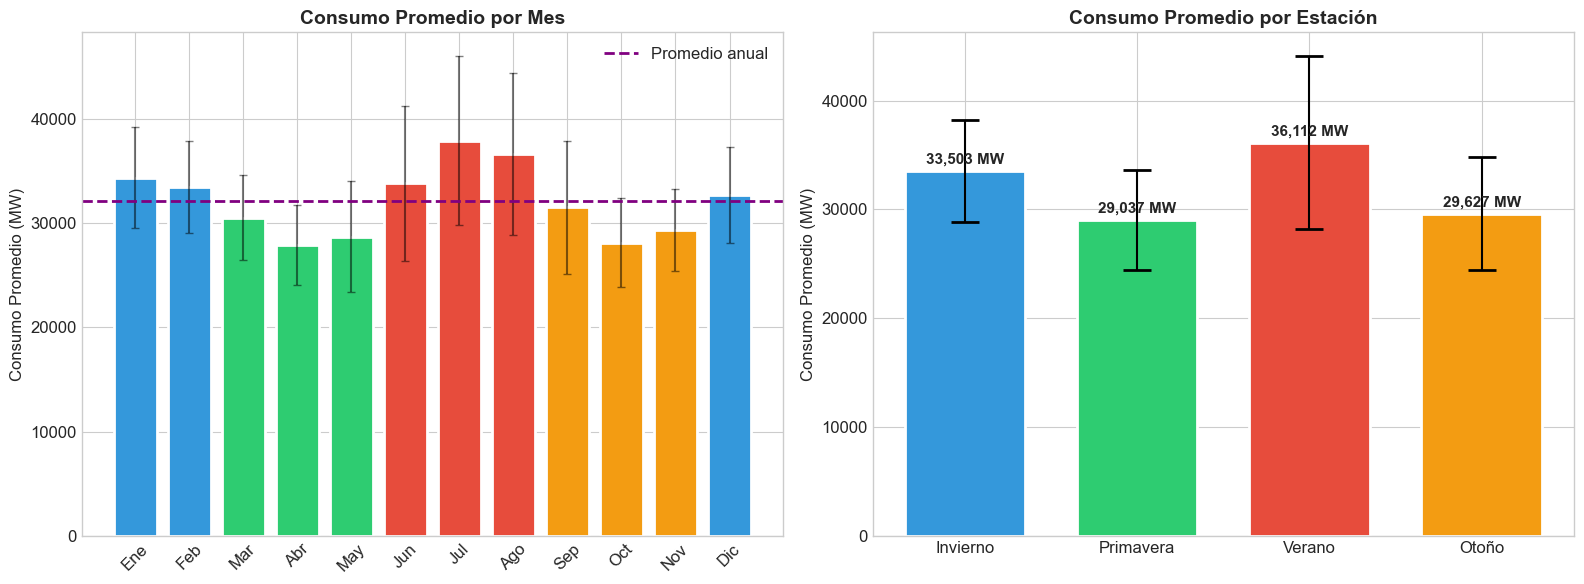

Análisis Estacional:

   Invierno: 33,503 MW promedio
   Primavera: 29,037 MW promedio
   Verano: 36,112 MW promedio
   Otoño: 29,627 MW promedio

   Mayor consumo: Verano
   Menor consumo: Primavera


In [40]:
# Consumo promedio por mes
monthly_pattern = df.groupby('Mes')['PJME_MW'].agg(['mean', 'std'])
monthly_pattern.index = month_names

# Colores por estación
season_colors = {
    'Invierno': '#3498db',   # Azul frío
    'Primavera': '#2ecc71', # Verde
    'Verano': '#e74c3c',    # Rojo/caliente
    'Otoño': '#f39c12'      # Naranja
}
colors_monthly = [season_colors['Invierno'], season_colors['Invierno'], season_colors['Primavera'],
                  season_colors['Primavera'], season_colors['Primavera'], season_colors['Verano'],
                  season_colors['Verano'], season_colors['Verano'], season_colors['Otoño'],
                  season_colors['Otoño'], season_colors['Otoño'], season_colors['Invierno']]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Consumo por mes
bars = axes[0].bar(monthly_pattern.index, monthly_pattern['mean'], color=colors_monthly, 
                   edgecolor='white', linewidth=2)
axes[0].errorbar(range(12), monthly_pattern['mean'], yerr=monthly_pattern['std'],
                 fmt='none', color='black', capsize=3, capthick=1, alpha=0.5)
axes[0].set_title('Consumo Promedio por Mes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Consumo Promedio (MW)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=monthly_pattern['mean'].mean(), color='purple', linestyle='--', 
                linewidth=2, label='Promedio anual')
axes[0].legend()

# Gráfico 2: Consumo por estación
seasonal_pattern = df.groupby('Estacion')['PJME_MW'].agg(['mean', 'std'])
seasonal_pattern = seasonal_pattern.reindex(season_order)

colors_season = [season_colors[s] for s in season_order]
bars2 = axes[1].bar(seasonal_pattern.index, seasonal_pattern['mean'], color=colors_season,
                    edgecolor='white', linewidth=2, width=0.7)
axes[1].errorbar(range(4), seasonal_pattern['mean'], yerr=seasonal_pattern['std'],
                 fmt='none', color='black', capsize=10, capthick=2)

# Añadir valores
for bar, val in zip(bars2, seasonal_pattern['mean']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 400, 
                 f'{val:,.0f} MW', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_title('Consumo Promedio por Estación', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Consumo Promedio (MW)')

plt.tight_layout()
plt.show()

print("Análisis Estacional:\n")
for season in season_order:
    print(f"   {season}: {seasonal_pattern.loc[season, 'mean']:,.0f} MW promedio")

max_season = seasonal_pattern['mean'].idxmax()
min_season = seasonal_pattern['mean'].idxmin()
print(f"\n   Mayor consumo: {max_season}")
print(f"   Menor consumo: {min_season}")

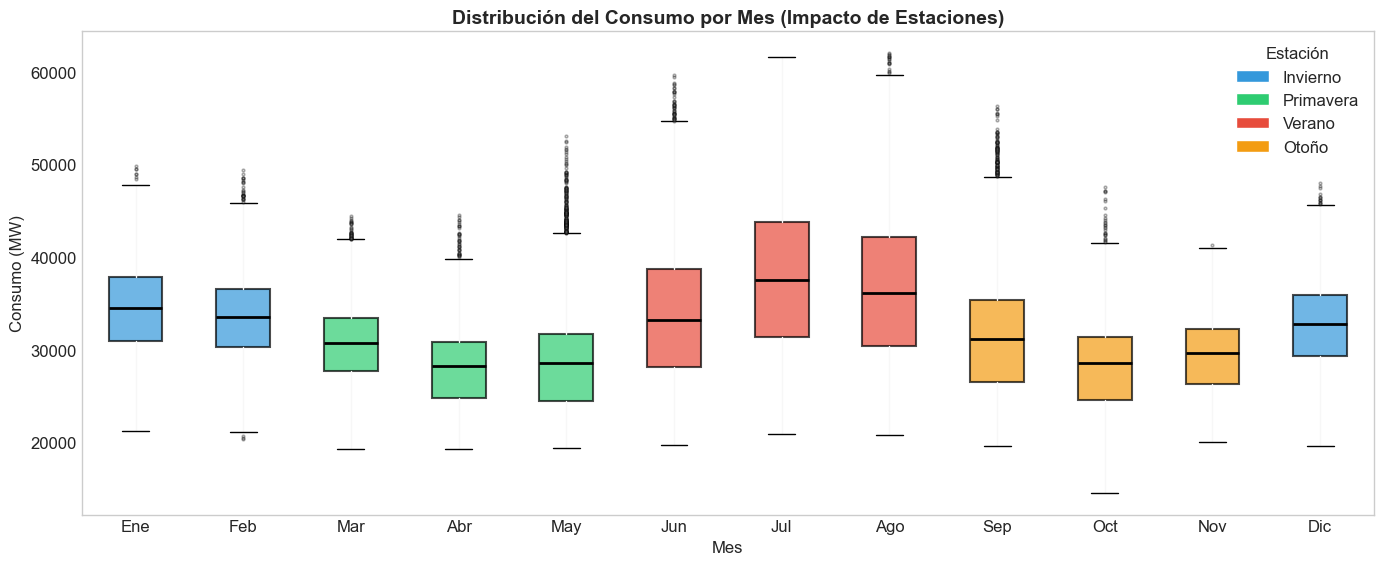

In [41]:
# Boxplot de consumo por mes para ver variabilidad
fig, ax = plt.subplots(figsize=(14, 6))

# Crear boxplot con colores por estación
bp = df.boxplot(column='PJME_MW', by='Mes', ax=ax, grid=False, patch_artist=True,
                boxprops=dict(linewidth=1.5),
                medianprops=dict(color='black', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=2, alpha=0.3))

# Colorear las cajas según la estación
colors_boxes = [season_colors['Invierno'], season_colors['Invierno'], season_colors['Primavera'],
                season_colors['Primavera'], season_colors['Primavera'], season_colors['Verano'],
                season_colors['Verano'], season_colors['Verano'], season_colors['Otoño'],
                season_colors['Otoño'], season_colors['Otoño'], season_colors['Invierno']]

for patch, color in zip(ax.patches, colors_boxes):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xticklabels(month_names)
ax.set_title('Distribución del Consumo por Mes (Impacto de Estaciones)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mes')
ax.set_ylabel('Consumo (MW)')
plt.suptitle('')

# Leyenda de estaciones
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=season_colors[s], edgecolor='white', label=s) for s in season_order]
ax.legend(handles=legend_elements, loc='upper right', title='Estación')

plt.tight_layout()
plt.show()

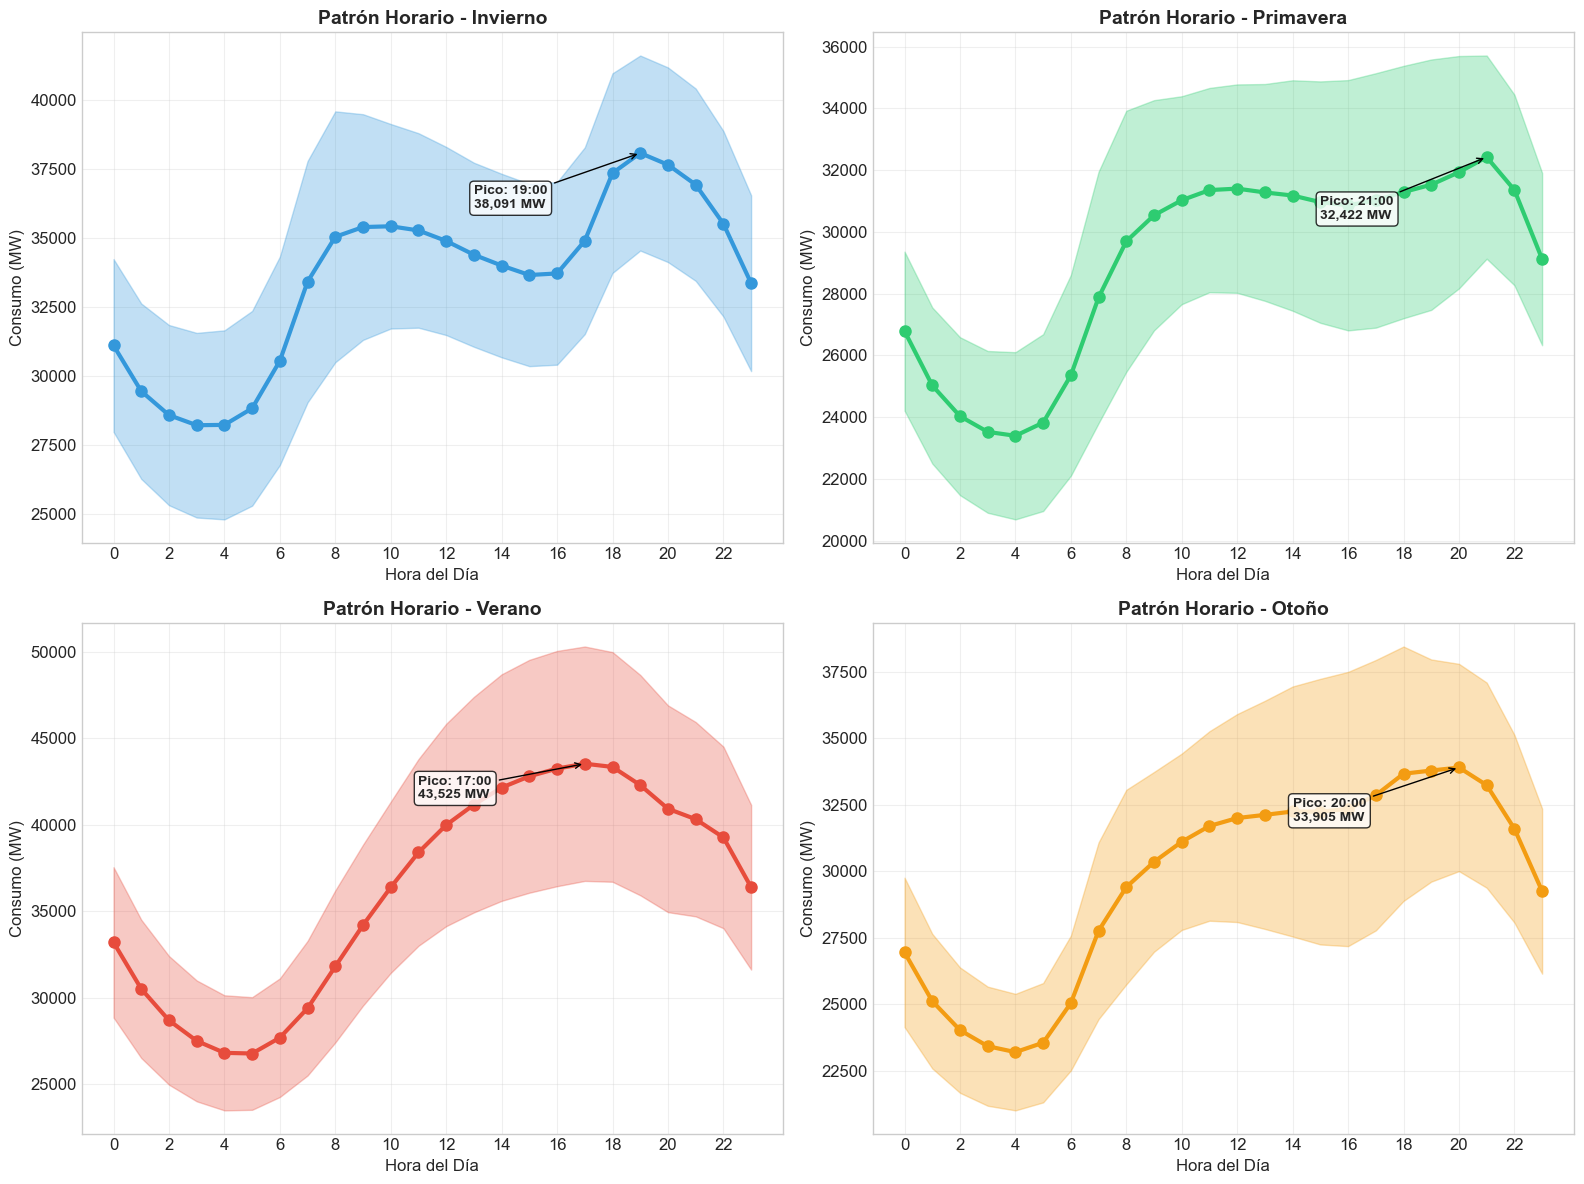


Observaciones del patrón estacional:
   Verano: Mayor consumo por uso de aire acondicionado
   Invierno: Alto consumo por calefacción eléctrica
   Primavera/Otoño: Menor consumo (temperaturas moderadas)


In [42]:
# Análisis horario por estación (efecto de calefacción/AC)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, season in enumerate(season_order):
    season_data = df[df['Estacion'] == season]
    hourly_season = season_data.groupby('Hora')['PJME_MW'].agg(['mean', 'std'])
    
    axes[idx].fill_between(hourly_season.index, 
                           hourly_season['mean'] - hourly_season['std'],
                           hourly_season['mean'] + hourly_season['std'],
                           alpha=0.3, color=season_colors[season])
    axes[idx].plot(hourly_season.index, hourly_season['mean'], 'o-', 
                   color=season_colors[season], linewidth=3, markersize=8)
    
    axes[idx].set_title(f'Patrón Horario - {season}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Hora del Día')
    axes[idx].set_ylabel('Consumo (MW)')
    axes[idx].set_xticks(range(0, 24, 2))
    axes[idx].grid(True, alpha=0.3)
    
    # Marcar máximo
    max_hour = hourly_season['mean'].idxmax()
    max_val = hourly_season['mean'].max()
    axes[idx].annotate(f'Pico: {max_hour}:00\n{max_val:,.0f} MW', 
                       xy=(max_hour, max_val),
                       xytext=(max_hour-6, max_val-2000),
                       arrowprops=dict(arrowstyle='->', color='black'),
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nObservaciones del patrón estacional:")
print("   Verano: Mayor consumo por uso de aire acondicionado")
print("   Invierno: Alto consumo por calefacción eléctrica")
print("   Primavera/Otoño: Menor consumo (temperaturas moderadas)")

---
## 4. 🔍 Identificación de Outliers

In [43]:
# Método 1: IQR (Rango Intercuartílico)
Q1 = df['PJME_MW'].quantile(0.25)
Q3 = df['PJME_MW'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['PJME_MW'] < lower_bound) | (df['PJME_MW'] > upper_bound)]

print(f"Detección de Outliers - Método IQR:")
print(f"   Q1: {Q1:,.0f} MW")
print(f"   Q3: {Q3:,.0f} MW")
print(f"   IQR: {IQR:,.0f} MW")
print(f"   Límite inferior: {lower_bound:,.0f} MW")
print(f"   Límite superior: {upper_bound:,.0f} MW")
print(f"   \n   Outliers detectados: {len(outliers_iqr):,} ({len(outliers_iqr)/len(df)*100:.2f}% del total)")

Detección de Outliers - Método IQR:
   Q1: 27,573 MW
   Q3: 35,650 MW
   IQR: 8,077 MW
   Límite inferior: 15,458 MW
   Límite superior: 47,766 MW
   
   Outliers detectados: 3,455 (2.38% del total)


In [44]:
# Método 2: Z-Score
z_scores = np.abs(stats.zscore(df['PJME_MW'].dropna()))
outliers_zscore = df[z_scores > 3]

print(f"\nDetección de Outliers - Método Z-Score (|z| > 3):")
print(f"Outliers detectados: {len(outliers_zscore):,} ({len(outliers_zscore)/len(df)*100:.2f}% del total)")


Detección de Outliers - Método Z-Score (|z| > 3):
Outliers detectados: 1,318 (0.91% del total)


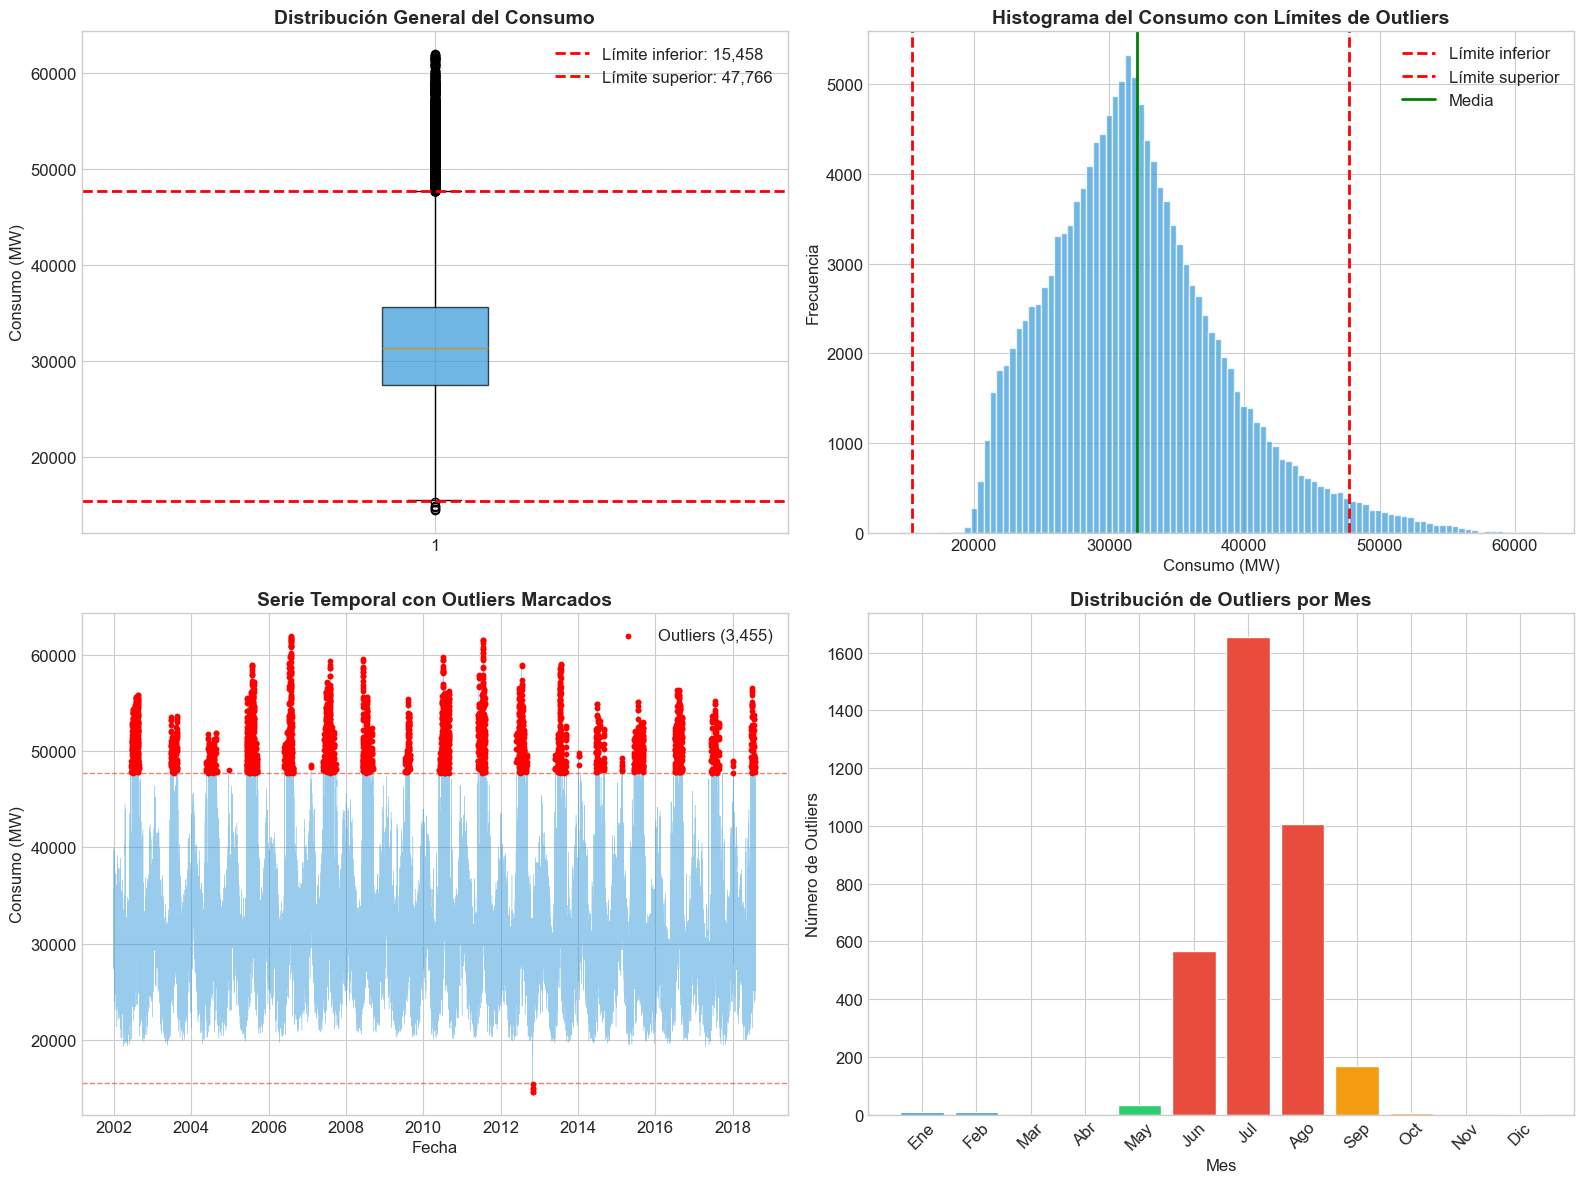

In [45]:
# Visualización de outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Boxplot general
bp = axes[0, 0].boxplot(df['PJME_MW'].dropna(), patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][0].set_alpha(0.7)
axes[0, 0].set_title('Distribución General del Consumo', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Consumo (MW)')
axes[0, 0].axhline(y=lower_bound, color='red', linestyle='--', linewidth=2, label=f'Límite inferior: {lower_bound:,.0f}')
axes[0, 0].axhline(y=upper_bound, color='red', linestyle='--', linewidth=2, label=f'Límite superior: {upper_bound:,.0f}')
axes[0, 0].legend()

# Gráfico 2: Histograma con límites
axes[0, 1].hist(df['PJME_MW'].dropna(), bins=100, color='#3498db', edgecolor='white', alpha=0.7)
axes[0, 1].axvline(x=lower_bound, color='red', linestyle='--', linewidth=2, label=f'Límite inferior')
axes[0, 1].axvline(x=upper_bound, color='red', linestyle='--', linewidth=2, label=f'Límite superior')
axes[0, 1].axvline(x=df['PJME_MW'].mean(), color='green', linestyle='-', linewidth=2, label=f'Media')
axes[0, 1].set_title('Histograma del Consumo con Límites de Outliers', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Consumo (MW)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# Gráfico 3: Serie temporal con outliers marcados
axes[1, 0].plot(df.index, df['PJME_MW'], color='#3498db', alpha=0.5, linewidth=0.3)
axes[1, 0].scatter(outliers_iqr.index, outliers_iqr['PJME_MW'], color='red', s=10, label=f'Outliers ({len(outliers_iqr):,})', zorder=5)
axes[1, 0].axhline(y=lower_bound, color='#e74c3c', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=upper_bound, color='#e74c3c', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 0].set_title('Serie Temporal con Outliers Marcados', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Fecha')
axes[1, 0].set_ylabel('Consumo (MW)')
axes[1, 0].legend()

# Gráfico 4: Distribución de outliers por mes
outliers_by_month = outliers_iqr.groupby(outliers_iqr.index.month).size()
all_months = pd.Series(0, index=range(1, 13))
all_months.update(outliers_by_month)
all_months.index = month_names

axes[1, 1].bar(all_months.index, all_months.values, color=colors_monthly, edgecolor='white', linewidth=1)
axes[1, 1].set_title('Distribución de Outliers por Mes', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('Número de Outliers')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [49]:
# Análisis detallado de outliers extremos
print("Top 10 valores más bajos (posibles errores de medición):")
print(df.nsmallest(10, 'PJME_MW')[['PJME_MW', 'Hora', 'DiaNombre', 'Mes', 'Estacion']])

print("\nTop 10 valores más altos:")
print(df.nlargest(10, 'PJME_MW')[['PJME_MW', 'Hora', 'DiaNombre', 'Mes', 'Estacion']])

Top 10 valores más bajos (posibles errores de medición):
                     PJME_MW  Hora DiaNombre  Mes Estacion
Datetime                                                  
2012-10-30 04:00:00  14544.0     4   Tuesday   10    Otoño
2012-10-30 03:00:00  14586.0     3   Tuesday   10    Otoño
2012-10-30 05:00:00  14821.0     5   Tuesday   10    Otoño
2012-10-30 02:00:00  14955.0     2   Tuesday   10    Otoño
2012-10-30 01:00:00  15390.0     1   Tuesday   10    Otoño
2012-10-30 06:00:00  15526.0     6   Tuesday   10    Otoño
2012-10-30 00:00:00  15919.0     0   Tuesday   10    Otoño
2012-10-30 07:00:00  16688.0     7   Tuesday   10    Otoño
2012-10-29 23:00:00  17422.0    23    Monday   10    Otoño
2012-10-30 08:00:00  17734.0     8   Tuesday   10    Otoño

Top 10 valores más altos:
                     PJME_MW  Hora  DiaNombre  Mes Estacion
Datetime                                                   
2006-08-02 17:00:00  62009.0    17  Wednesday    8   Verano
2006-08-02 16:00:00  61909.0

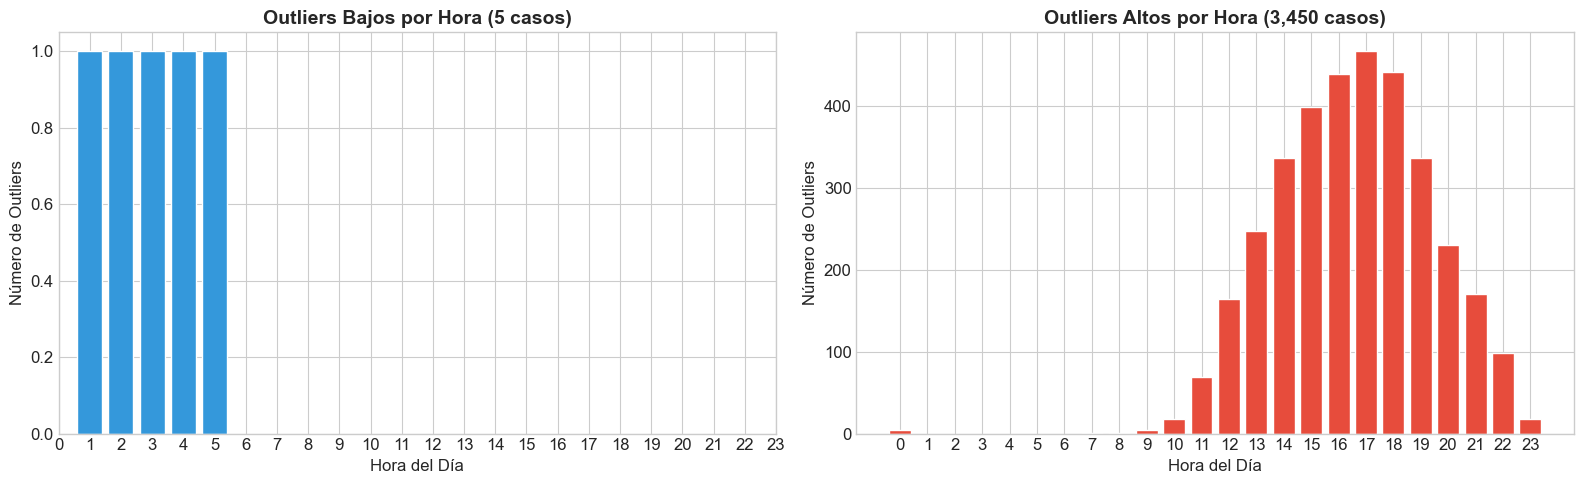

Resumen de Outliers:
   Outliers bajos (< 15,458 MW): 5
   Outliers altos (> 47,766 MW): 3,450

   Los outliers bajos podrían indicar:
      - Errores de medición/sensores
      - Cortes de energía
      - Problemas de transmisión de datos


In [47]:
# Analizar outliers por tipo (altos vs bajos)
outliers_bajos = df[df['PJME_MW'] < lower_bound]
outliers_altos = df[df['PJME_MW'] > upper_bound]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Outliers bajos por hora
if len(outliers_bajos) > 0:
    outliers_bajos_hora = outliers_bajos.groupby('Hora').size()
    axes[0].bar(outliers_bajos_hora.index, outliers_bajos_hora.values, color='#3498db', edgecolor='white')
    axes[0].set_title(f'Outliers Bajos por Hora ({len(outliers_bajos):,} casos)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Hora del Día')
    axes[0].set_ylabel('Número de Outliers')
    axes[0].set_xticks(range(0, 24))
else:
    axes[0].text(0.5, 0.5, 'No hay outliers bajos', ha='center', va='center', fontsize=14)
    axes[0].set_title('Outliers Bajos por Hora', fontsize=14, fontweight='bold')

# Outliers altos por hora
if len(outliers_altos) > 0:
    outliers_altos_hora = outliers_altos.groupby('Hora').size()
    axes[1].bar(outliers_altos_hora.index, outliers_altos_hora.values, color='#e74c3c', edgecolor='white')
    axes[1].set_title(f'Outliers Altos por Hora ({len(outliers_altos):,} casos)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Hora del Día')
    axes[1].set_ylabel('Número de Outliers')
    axes[1].set_xticks(range(0, 24))
else:
    axes[1].text(0.5, 0.5, 'No hay outliers altos', ha='center', va='center', fontsize=14)
    axes[1].set_title('Outliers Altos por Hora', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Resumen de Outliers:")
print(f"   Outliers bajos (< {lower_bound:,.0f} MW): {len(outliers_bajos):,}")
print(f"   Outliers altos (> {upper_bound:,.0f} MW): {len(outliers_altos):,}")

if len(outliers_bajos) > 0:
    print(f"\n   Los outliers bajos podrían indicar:")
    print(f"      - Errores de medición/sensores")
    print(f"      - Cortes de energía")
    print(f"      - Problemas de transmisión de datos")

---
## 5. Resumen Ejecutivo del EDA

In [48]:
print("Resumen Ejecutivo del EDA")

print(f"\n Dataset:")
print(f"   • Registros: {len(df):,}")
print(f"   • Período: {df.index.min().strftime('%Y-%m-%d')} a {df.index.max().strftime('%Y-%m-%d')}")
print(f"   • Duración: {(df.index.max() - df.index.min()).days / 365:.1f} años")

print(f"\n Estadísticas Generales:")
print(f"   • Consumo promedio: {df['PJME_MW'].mean():,.0f} MW")
print(f"   • Desviación estándar: {df['PJME_MW'].std():,.0f} MW")
print(f"   • Mínimo: {df['PJME_MW'].min():,.0f} MW")
print(f"   • Máximo: {df['PJME_MW'].max():,.0f} MW")

print(f"\n Estacionalidad Diaria:")
print(f"   • Hora pico: {hourly_pattern['mean'].idxmax()}:00 ({hourly_pattern['mean'].max():,.0f} MW)")
print(f"   • Hora valle: {hourly_pattern['mean'].idxmin()}:00 ({hourly_pattern['mean'].min():,.0f} MW)")

print(f"\n Estacionalidad Semanal:")
print(f"   • Días laborables: {weekday_weekend.loc['Días Laborables', 'mean']:,.0f} MW promedio")
print(f"   • Fin de semana: {weekday_weekend.loc['Fin de Semana', 'mean']:,.0f} MW promedio")
print(f"   • Diferencia: {diff_pct:.1f}% mayor en días laborables")

print(f"\n Estacionalidad Anual:")
print(f"   • Mayor consumo: {seasonal_pattern['mean'].idxmax()} ({seasonal_pattern['mean'].max():,.0f} MW)")
print(f"   • Menor consumo: {seasonal_pattern['mean'].idxmin()} ({seasonal_pattern['mean'].min():,.0f} MW)")

print(f"\n Outliers:")
print(f"   • Total detectados (IQR): {len(outliers_iqr):,} ({len(outliers_iqr)/len(df)*100:.2f}%)")
print(f"   • Outliers bajos: {len(outliers_bajos):,}")
print(f"   • Outliers altos: {len(outliers_altos):,}")

Resumen Ejecutivo del EDA

 Dataset:
   • Registros: 145,366
   • Período: 2002-01-01 a 2018-08-03
   • Duración: 16.6 años

 Estadísticas Generales:
   • Consumo promedio: 32,080 MW
   • Desviación estándar: 6,464 MW
   • Mínimo: 14,544 MW
   • Máximo: 62,009 MW

 Estacionalidad Diaria:
   • Hora pico: 19:00 (36,427 MW)
   • Hora valle: 4:00 (25,415 MW)

 Estacionalidad Semanal:
   • Días laborables: 32,996 MW promedio
   • Fin de semana: 29,788 MW promedio
   • Diferencia: 10.8% mayor en días laborables

 Estacionalidad Anual:
   • Mayor consumo: Verano (36,112 MW)
   • Menor consumo: Primavera (29,037 MW)

 Outliers:
   • Total detectados (IQR): 3,455 (2.38%)
   • Outliers bajos: 5
   • Outliers altos: 3,450
